[<font color='steelblue'>1. - __EDA__</font>](#one-bullet) <br>
    [<font color='steelblue'>1.1. - Imports</font>](#two-bullet) <br>
    [<font color='steelblue'>1.2. - Initial Analysis</font>](#three-bullet) <br>
    [<font color='steelblue'>1.3. - Missing Values</font>](#four-bullet) <br>
    [<font color='steelblue'>1.4. - Feature Engineering</font>](#five-bullet) <br>
    [<font color='steelblue'>1.5. - Outliers</font>](#six-bullet) <br>
    [<font color='steelblue'>1.6. - Cleaning Text</font>](#seven-bullet) <br>

[<font color='steelblue'>2. - __Models__</font>](#eight-bullet) <br>
    [<font color='steelblue'>2.1. - Functions</font>](#nine-bullet) <br>
    [<font color='steelblue'>2.2. - Models</font>](#ten-bullet) <br>
    [<font color='steelblue'>2.3. - PreTrained Models</font>](#eleven-bullet) <br>
    [<font color='steelblue'>2.4. - Results</font>](#twelve-bullet) <br>

Group 7
|Name | Student ID |
|----|----|
|Joana Rodrigues| 20240603|
|Mara Simões| 20240326|
|Matilde Street| 20240523|
|Rafael Silva| 20240511|

<hr>
<a class="anchor" id="one-bullet"> 
<d style="color:white;">

## 1. EDA
</a> 
</d>   

<a class="anchor" id="two-bullet"> 
<d style="color:white;">

### 1.1. Imports
</a> 
</d>   

In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [266]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from textblob import TextBlob
from wordcloud import WordCloud
# from langdetect import detect
# from googletrans import Translator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

# # # Download NLTK resources
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [267]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.DataFrame(data=df_train, columns=['text', 'label']).reset_index(drop=True)
df_test = pd.DataFrame(data=df_test, columns=['text', 'label']).reset_index(drop=True)

print(df_train.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


<a class="anchor" id="three-bullet"> 
<d style="color:white;">

### 1.2. Initial Analysis
</a> 
</d>   

In [268]:
print('Initial dataset contains ', df_train.shape[0], 'rows and ', df_train.shape[1], 'columns')

Initial dataset contains  9543 rows and  2 columns


The dataset contains 3 unique labels to predict.
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


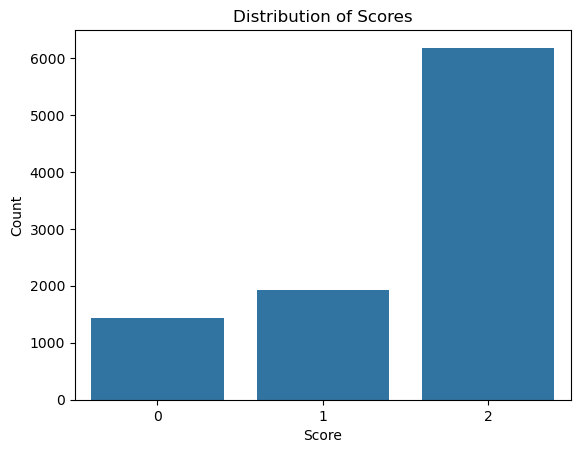

In [269]:
print('The dataset contains', df_train['label'].nunique(), 'unique labels to predict.')
print(df_train['label'].value_counts())
# Visualize distribution of satisfaction
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [270]:
df_train['label'].describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

<Axes: >

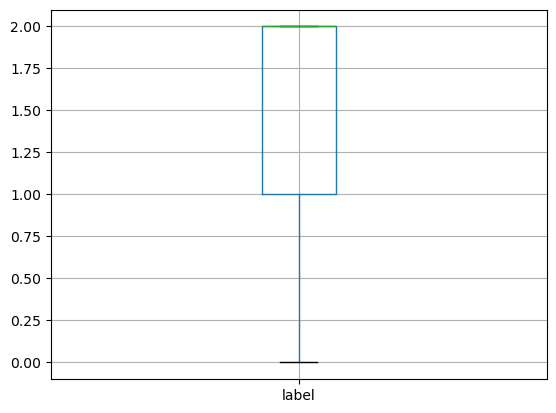

In [271]:
df_train.boxplot(['label'])

To see the words that appear the most in our dataset

In [272]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

There appears the same word 'the' for example twice because it is in lower and upper case. Therefore we will have to deal with that in the preprocessing steps.

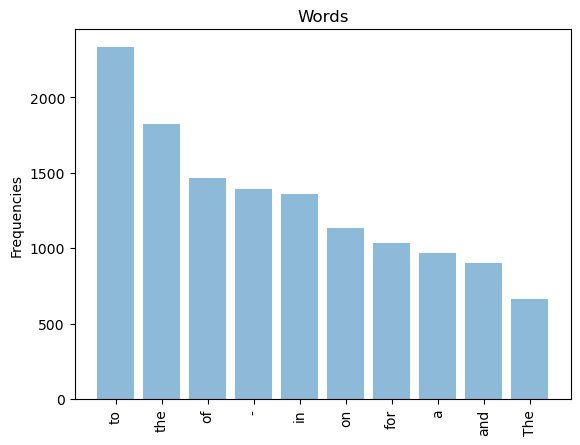

In [273]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

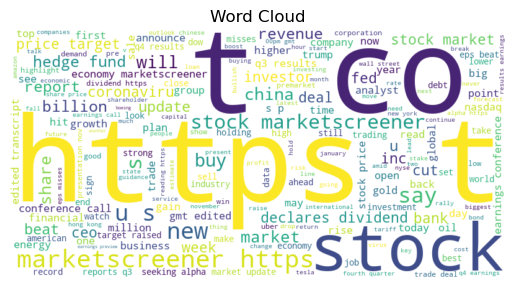

In [274]:
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

<a class="anchor" id="four-bullet"> 
<d style="color:white;">

### 1.3. Missing Values
</a> 
</d>   

In [275]:
if df_train.isnull().sum().sum() > 0:
    print('There are missing values in the dataset')
else: 
    print('There are no missing values in the dataset')  

There are no missing values in the dataset


<a class="anchor" id="five-bullet"> 
<d style="color:white;">

### 1.4. Feature Engineering
</a> 
</d>   

In [276]:
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))

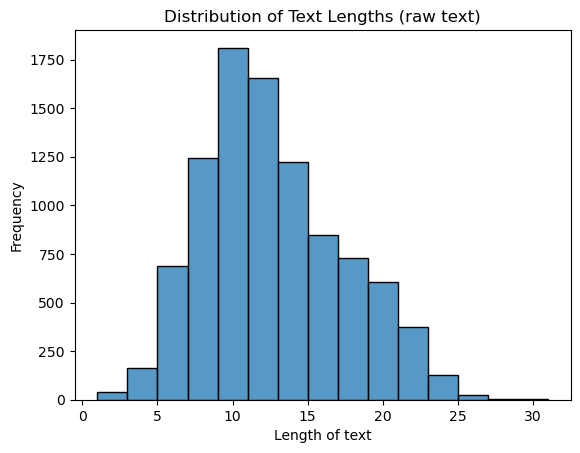

In [277]:
#Plot distribution of text length
sns.histplot(df_train['word_count'], bins=15)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [278]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

<a class="anchor" id="six-bullet"> 
<d style="color:white;">

### 1.5. Outliers
</a> 
</d>   

In [279]:
to_remove = df_train['text_length'].quantile(0.005)

print('We will eliminate the texts with less than', to_remove, 'length')  #0.5 percentile

#to see where the labels of the errors
removed_labels = df_train[df_train['text_length'] < 18]['label'].value_counts()
print(removed_labels)

#to see what is being eliminated:
removed = df_train.loc[df_train['text_length'] < 18, ['text', 'label', 'text_length']]
print(removed)

df_train = df_train[df_train['text_length'] >= 18]
df_train = df_train[df_train['text_length'] >= 18].reset_index(drop=True)

We will eliminate the texts with less than 18.0 length
label
2    42
1     5
Name: count, dtype: int64
                   text  label  text_length
1858   SASA聚酯选用英威达PTA技术      2           16
3090          Brent +4%      1            9
3943                 :)      2            2
3948            @TicToc      2            7
3980      100% Correct!      2           13
4358  Cya Jason Garrett      2           17
4360               Damn      2            4
4440                 F5      2            2
4914         Next week.      2           10
5006      Racing on Ice      2           13
5484    Wholesale Trade      2           15
5512         Woke Sachs      2           10
5654         $penn coin      2           10
6511     Housing Starts      2           14
6849     Nasdaq up 0.2%      1           14
6990  Averages end flat      2           17
7935      $WW heavy....      1           13
8055          Long $WMT      1            9
8153    $APOP on scans.      2           15
8167       $CEI W

<a class="anchor" id="seven-bullet"> 
<d style="color:white;">

### 1.6. Cleaning Text
</a> 
</d>   

#### 1.6.1. All text in english

Mudança para a mesma lingua (não serviu de nada)

In [280]:
# def detect_language(text):
#     try:
#         return detect(text)  
#     except:
#         return 'unknown' 

# df_train['language'] = df_train['text'].apply(detect_language)

# language_distribution = df_train['language'].value_counts()

# print(language_distribution)

# print( df_train[df_train['language'] == 'unknown'], 'tweets with unknown language.')

In [281]:
# initial_rows = len(df_train)

# language_counts = df_train['language'].value_counts()

# languages_to_keep = language_counts[language_counts > 1].index

# df_train = df_train[df_train['language'].isin(languages_to_keep)]

# final_rows = len(df_train)

# removed_rows = initial_rows - final_rows
# print(f"{removed_rows} linhas foram removidas.")


In [282]:
# translator = Translator()

# def translate_to_english(text, detected_language):
#     try:
#         if detected_language != 'en':
#             translated = translator.translate(text, src=detected_language, dest='en')
#             return translated.text
#         else:
#             return text
#     except Exception as e:
#         print(f"Error translating text: {e}")
#         return text

# df_train['translated_text'] = df_train.apply(
#     lambda row: translate_to_english(row['text'], row['language']),
#     axis=1)


# df_french = df_train[df_train['language'] == 'pt']
# df_french[['text', 'clean_text']].head(20)

#### 1.6.2. Cleaning text

Application of a formula that will:
1. Remove the stopwords
2. Stemeatize & Lematize
3. Put everything in lowercase
3. Remove weird characters

In [283]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean(text_list, stopwords=True, lemmatize=True, stem=False,correct_spelling=False):
    cleaned = []

    for text in tqdm(text_list):
        text = text.lower()

        text = re.sub("[^a-zA-Z]", " ", text)
        text = re.sub("br", "", text)
        text = re.sub(r"http\S+", "", text)
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        if stopwords:
            text = " ".join([word for word in text.split() if word not in stop])

        if correct_spelling:
            text = str(TextBlob(text).correct())

        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        if stem:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned.append(text)

    return cleaned

df_train['clean_text'] = clean(df_train['text'], stopwords=True, lemmatize=True, stem=False, correct_spelling=False)
df_test['clean_text'] = clean(df_test['text'], stopwords=True, lemmatize=True, stem=False)

df_train[['text', 'clean_text']].head()

100%|██████████| 2388/2388 [00:00<00:00, 23880.31it/s]


,text,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,bynd jpmorgan reel expectation beyond meat co ...
1,$CCL $RCL - Nomura points to bookings weakness...,ccl rcl nomura point booking weakness carnival...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",cx cemex cut credit suisse j p morgan weak bui...
3,$ESS: BTIG Research cuts to Neutral https://t....,es btig research cut neutral co mcyftsxc n
4,$FNKO - Funko slides after Piper Jaffray PT cu...,fnko funko slide piper jaffray pt cut co z ijm...


#### 1.6.3. Removing unsual words

In [284]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train['clean_text'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
words_once = [word for word, count in zip(words, word_counts) if count == 1]

print("Words that appear only once:", words_once)

Words that appear only once: ['aaa', 'aac', 'aacitcwia', 'aacy', 'aaham', 'aakmr', 'aams', 'aaon', 'aapemwrmvn', 'aapiyhqm', 'aasl', 'aav', 'aawthd', 'aaww', 'aaza', 'abalone', 'abandoned', 'abandoning', 'abbott', 'abcdo', 'abdefgjwlz', 'abe', 'abebe', 'aben', 'abeo', 'aberdeen', 'abeviated', 'abhjrhyhfd', 'abiy', 'abjk', 'abk', 'abl', 'abmzokmqwl', 'abn', 'abo', 'abohhqlbea', 'abolish', 'aborted', 'absol', 'absorb', 'absurdity', 'abu', 'abukarsh', 'abusing', 'abv', 'abxui', 'aca', 'academic', 'acbah', 'acbvso', 'acceleron', 'acceleronpharma', 'accendowave', 'acceptance', 'accessing', 'accesswi', 'acciones', 'accommodate', 'accomplish', 'accomplished', 'accor', 'accordi', 'accordingly', 'accretive', 'accumulated', 'accumulating', 'accuracy', 'accurately', 'accusation', 'accuses', 'acd', 'acea', 'acelerada', 'acelrx', 'ach', 'achieved', 'achieving', 'acj', 'acknowledged', 'acknowledging', 'acme', 'acmr', 'acn', 'acnotpflvt', 'acorncapitalinvestmentfund', 'acpkbt', 'acpnfs', 'acpohatzzq'

In [285]:
words_once_set = set(words_once)

def remove_rare_words(text):
    return ' '.join([word for word in text.split() if word not in words_once_set])

df_train['clean_text'] = df_train['clean_text'].apply(remove_rare_words)

<hr>
<a class="anchor" id="eight-bullet"> 
<d style="color:white;">

## 2. Models
</a> 
</d>   

In [286]:
X_train = df_train['clean_text']
y_train = df_train['label'] 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=df_train['label'], random_state=42)

<a class="anchor" id="nine-bullet"> 
<d style="color:white;">

### 2.1. Functions
</a> 
</d>   

#### 2.1.1. Vectorization

In [287]:
def bow_or_tfidf(texts = df_train['clean_text'], method='bow'):
    if method == 'bow':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    else:
        raise ValueError("Choose a valid method: 'bow', 'tfidf'.")

#X_train, vectorizer = bow_or_tfidf(df_train['clean_text'], method='bow')
# X_train, vectorizer = bow_or_tfidf(df_train['clean_text'], method='tfidf')


#### 2.1.2. Function for evaluation of the model

In [288]:
def evaluate_model_predictions(y_pred_train, y_pred_val, y_train = y_train, y_val = y_val, show_confusion_matrix = True, show_classification_report = True):
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='macro')

    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')

    print(f"Accuracy of train: {train_accuracy:.4f}")
    print(f"F1 Macro (Train): {train_f1:.4f}")
    print(f"Accuracy of val: {val_accuracy:.4f}")
    print(f"\033[1mF1 Macro (Val)\033[0m: {val_f1:.4f}")
    print(f"Precision (Val): {val_precision:.4f}")
    print(f"Recall (Val): {val_recall:.4f}")
    
    
    if show_confusion_matrix==True:
        print('\nConfusion Matrix for Validation Data:')    
        print(confusion_matrix(y_val, y_pred_val))

    if show_classification_report==True:
        print('\nClassification Report for Validation Data:')
        print(classification_report(y_val, y_pred_val))

    return train_accuracy, train_f1, val_accuracy, val_f1

<a class="anchor" id="ten-bullet"> 
<d style="color:white;">

### 2.2. Models
</a> 
</d> 

#### 2.2.1. Naive Bayes

With BOW

In [289]:
X_train_bow, vectorizer = bow_or_tfidf(X_train, method='bow')
X_val_bow = vectorizer.transform(X_val)
#X_test_bow = vectorizer.transform(df_test['clean_text']) 

nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
y_pred_train = nb.predict(X_train_bow)
y_pred_val = nb.predict(X_val_bow)

# Results
nb_bow_train_accuracy, nb_bow_train_f1_macro, nb_bow_val_accuracy, nb_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.8861
F1 Macro (Train): 0.8496
Accuracy of val: 0.7711
F1 Macro (Val): 0.6773
Precision (Val): 0.7019
Recall (Val): 0.6607

Confusion Matrix for Validation Data:
[[ 138   50  100]
 [  24  236  124]
 [  56   81 1091]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55       288
           1       0.64      0.61      0.63       384
           2       0.83      0.89      0.86      1228

    accuracy                           0.77      1900
   macro avg       0.70      0.66      0.68      1900
weighted avg       0.76      0.77      0.76      1900



With TF-IDF

In [290]:
X_train_tfidf, vectorizer = bow_or_tfidf(X_train, method='tfidf')
X_val_tfidf = vectorizer.transform(X_val)
#X_test_tfidf = vectorizer.transform(df_test['clean_text']) 

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_train = nb.predict(X_train_tfidf)
y_pred_val = nb.predict(X_val_tfidf)

# Results
nb_idf_train_accuracy, nb_idf_train_f1_macro, nb_idf_val_accuracy, nb_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7790
F1 Macro (Train): 0.6308
Accuracy of val: 0.7332
F1 Macro (Val): 0.5254
Precision (Val): 0.8283
Recall (Val): 0.4965

Confusion Matrix for Validation Data:
[[  40   18  230]
 [   2  139  243]
 [   0   14 1214]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.95      0.14      0.24       288
           1       0.81      0.36      0.50       384
           2       0.72      0.99      0.83      1228

    accuracy                           0.73      1900
   macro avg       0.83      0.50      0.53      1900
weighted avg       0.77      0.73      0.68      1900



#### 2.2.2. Logistic Regression 

With BOW

In [291]:
lr = LogisticRegression()
lr.fit(X_train_bow, y_train)
y_pred_train = lr.predict(X_train_bow)
y_pred_val = lr.predict(X_val_bow)

# Results:
lr_bow_train_accuracy, lr_bow_train_f1_macro, lr_bow_val_accuracy, lr_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9577
F1 Macro (Train): 0.9437
Accuracy of val: 0.7811
F1 Macro (Val): 0.6768
Precision (Val): 0.7398
Recall (Val): 0.6421

Confusion Matrix for Validation Data:
[[ 130   28  130]
 [  25  208  151]
 [  38   44 1146]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.67      0.45      0.54       288
           1       0.74      0.54      0.63       384
           2       0.80      0.93      0.86      1228

    accuracy                           0.78      1900
   macro avg       0.74      0.64      0.68      1900
weighted avg       0.77      0.78      0.77      1900



With TF-IDF

In [292]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_train = lr.predict(X_train_tfidf)
y_pred_val = lr.predict(X_val_tfidf)

# Results:
lr_idf_train_accuracy, lr_idf_train_f1_macro, lr_idf_val_accuracy, lr_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.8537
F1 Macro (Train): 0.7857
Accuracy of val: 0.7663
F1 Macro (Val): 0.6295
Precision (Val): 0.7748
Recall (Val): 0.5829

Confusion Matrix for Validation Data:
[[  94   24  170]
 [  11  175  198]
 [  15   26 1187]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.78      0.33      0.46       288
           1       0.78      0.46      0.57       384
           2       0.76      0.97      0.85      1228

    accuracy                           0.77      1900
   macro avg       0.77      0.58      0.63      1900
weighted avg       0.77      0.77      0.74      1900



#### 2.2.3. KNN

With BOW

In [293]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_bow, y_train)

y_pred_train = knn.predict(X_train_bow)
y_pred_val = knn.predict(X_val_bow)

knn_bow_train_accuracy, knn_bow_train_f1_macro, knn_bow_val_accuracy, knn_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7956
F1 Macro (Train): 0.6777
Accuracy of val: 0.7058
F1 Macro (Val): 0.5111
Precision (Val): 0.6689
Recall (Val): 0.4834

Confusion Matrix for Validation Data:
[[  58   18  212]
 [  11  114  259]
 [  30   29 1169]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.59      0.20      0.30       288
           1       0.71      0.30      0.42       384
           2       0.71      0.95      0.82      1228

    accuracy                           0.71      1900
   macro avg       0.67      0.48      0.51      1900
weighted avg       0.69      0.71      0.66      1900



#### 2.2.4. MLP

With BOW

In [294]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
mlp.fit(X_train_bow, y_train)

y_pred_train = mlp.predict(X_train_bow)
y_pred_val = mlp.predict(X_val_bow)

mlp_bow_train_accuracy, mlp_bow_train_f1_macro, mlp_bow_val_accuracy, mlp_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)


Accuracy of train: 0.9872
F1 Macro (Train): 0.9838
Accuracy of val: 0.7474
F1 Macro (Val): 0.6493
Precision (Val): 0.6575
Recall (Val): 0.6425

Confusion Matrix for Validation Data:
[[ 142   58   88]
 [  44  220  120]
 [  70  100 1058]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       288
           1       0.58      0.57      0.58       384
           2       0.84      0.86      0.85      1228

    accuracy                           0.75      1900
   macro avg       0.66      0.64      0.65      1900
weighted avg       0.74      0.75      0.74      1900



c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### 2.2.5. LSTM

In [295]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=100, padding='post', truncating='post')

# Convert labels to one-hot
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# Ensure dtype is correct to avoid "Invalid dtype: object"
X_train_pad = np.array(X_train_pad, dtype='int32')
X_val_pad = np.array(X_val_pad, dtype='int32')
y_train_cat = np.array(y_train_cat, dtype='float32')
y_val_cat = np.array(y_val_cat, dtype='float32')

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val_cat))

# Predict 
y_pred_train = model.predict(X_train_pad)
y_pred_val = model.predict(X_val_pad)

# Convert predictions to class labels
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)

# Also convert true labels to integers
y_train_labels = np.argmax(y_train_cat, axis=1)
y_val_labels = np.argmax(y_val_cat, axis=1)

# Evaluate 
lstm_train_acc, lstm_train_f1, lstm_val_acc, lstm_val_f1 = evaluate_model_predictions(
    y_pred_train_labels, y_pred_val_labels,
    y_train=y_train_labels, y_val=y_val_labels
)

c:\Users\paulo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6477 - loss: 0.9082 - val_accuracy: 0.6463 - val_loss: 0.8929
Epoch 2/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6429 - loss: 0.8987 - val_accuracy: 0.6463 - val_loss: 0.8972
Epoch 3/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6470 - loss: 0.8947 - val_accuracy: 0.6463 - val_loss: 0.8914
Epoch 4/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6433 - loss: 0.8976 - val_accuracy: 0.6463 - val_loss: 0.8936
Epoch 5/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6487 - loss: 0.8905 - val_accuracy: 0.6463 - val_loss: 0.8916
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy of train: 0.6461
F1 Macro (Train): 0.2617
Accuracy of val: 0.6463
F1 Macro (Val): 0.2617
Precision (Val): 0.2154
Recall (Val): 0.3333

Confusion Matrix for Validation Data:
[[   0    0  288]
 [   0    0  384]
 [   0    0 1228]]

Classification Report for Validation Data:

c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paulo\anaconda3\Lib\site-packag

<a class="anchor" id="eleven-bullet"> 
<d style="color:white;">

### 2.3. PreTrained Models
</a> 
</d> 

In [296]:
# Train the Word2Vec model only once
tokenized_train = [text.split() for text in X_train]
model = Word2Vec(sentences=tokenized_train, vector_size=100, window=2, min_count=1, sg=1)
word_vectors = model.wv

# Function only to generate the document embedding
def get_doc_embedding(doc, word_vectors, dim=100):
    tokens = doc.split()
    vectors = [word_vectors[word] for word in tokens if word in word_vectors.index_to_key]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# Create the embeddings efficiently
X_train_emb = np.vstack([get_doc_embedding(doc, word_vectors) for doc in X_train])
X_val_emb = np.vstack([get_doc_embedding(doc, word_vectors) for doc in X_val])

clf = LogisticRegression()
clf.fit(X_train_emb, y_train)

y_pred_train = clf.predict(X_train_emb)
y_pred_val = clf.predict(X_val_emb)

lr_emb_train_accuracy, lr_emb_train_f1_macro, lr_emb_val_accuracy, lr_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.6610
F1 Macro (Train): 0.3396
Accuracy of val: 0.6605
F1 Macro (Val): 0.3315
Precision (Val): 0.4082
Recall (Val): 0.3687

Confusion Matrix for Validation Data:
[[   0   17  271]
 [   0   47  337]
 [   0   20 1208]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       288
           1       0.56      0.12      0.20       384
           2       0.67      0.98      0.79      1228

    accuracy                           0.66      1900
   macro avg       0.41      0.37      0.33      1900
weighted avg       0.54      0.66      0.55      1900



c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paulo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paulo\anaconda3\Lib\site-packag

<a class="anchor" id="twelve-bullet"> 
<d style="color:white;">

### 2.4. Results
</a> 
</d> 

Naive Bayes and Logistic Regression - BOW vs TF-IDF

In [297]:
# Define model results dictionary

model_results = {
    'Simple Models': [
        'NB_BOW', 'NB_IDF', 'LR_BOW', 'LR_IDF', 
    ],
    'Train Accuracy': [
        nb_bow_train_accuracy, nb_idf_train_accuracy, lr_bow_train_accuracy, lr_idf_train_accuracy
    ],
    'Val Accuracy': [
        nb_bow_val_accuracy, nb_idf_val_accuracy, lr_bow_val_accuracy, lr_idf_val_accuracy,
    ],
    'Train F1 Score': [
        nb_bow_train_f1_macro, nb_idf_train_f1_macro, lr_bow_train_f1_macro, lr_idf_train_f1_macro, 
    ],
    'Val F1 Score': [
        nb_bow_val_f1_macro, nb_idf_val_f1_macro, lr_bow_val_f1_macro, lr_idf_val_f1_macro
    ]
}

# Create DataFrame with the results
results_models = pd.DataFrame(model_results)

# Set 'Simple Models' column as the index
results_models.set_index('Simple Models', inplace=True)

results_models

,Train Accuracy,Val Accuracy,Train F1 Score,Val F1 Score
Simple Models,,,,
NB_BOW,0.886124,0.771053,0.849595,0.677331
NB_IDF,0.778963,0.733158,0.630829,0.525419
LR_BOW,0.957741,0.781053,0.943739,0.676774
LR_IDF,0.853739,0.766316,0.785701,0.331516


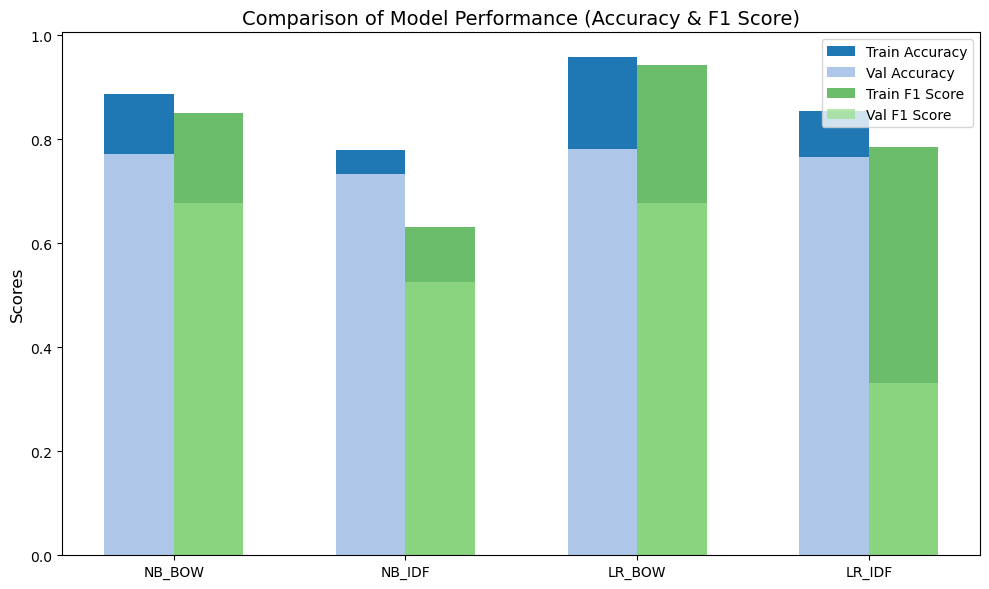

In [298]:
model_names = results_models.index

train_accuracy = results_models['Train Accuracy']
val_accuracy = results_models['Val Accuracy']
train_f1 = results_models['Train F1 Score']
val_f1 = results_models['Val F1 Score']

bar_width = 0.3
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))

bar_tra = ax.bar(index - bar_width / 2, train_accuracy, bar_width, label='Train Accuracy', color='#1F77B4' )
bar_ta = ax.bar(index - bar_width / 2, val_accuracy, bar_width, label='Val Accuracy', color='#AEC7E8')

bar_trf = ax.bar(index + bar_width / 2, train_f1, bar_width, label='Train F1 Score', alpha=0.7, color= '#2CA02C' )
bar_tf = ax.bar(index + bar_width / 2, val_f1, bar_width, label='Val F1 Score', alpha=0.7, color='#98DF8A')

ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance (Accuracy & F1 Score)', fontsize=14)

ax.set_xticks(index)
ax.set_xticklabels(model_names)

ax.legend()

plt.tight_layout()
plt.show()


The best model is... so we will do the val set with those predictions

In [299]:
#y_pred_val =lr.predict(X_val_tfidf)


# ids = pd.DataFrame(df_val.index) 
# predict_df = pd.DataFrame(y_pred_val, columns=['label'])

# final = pd.concat([ids, predict_df], axis=1)

# final.reset_index(drop=True, inplace=True)
# final.to_csv('df_val_prediction.csv', index=False)